# IEA CCS and PV forecasts: porcupine plots

Based on the work of Rory French. rory@koboldmetals.com.

Compiled by Lindsey Gulden, February 2025. lindsey@legupdata.com.

See explanation of methods [here](https://docs.google.com/document/d/16Hfk0xczmcDSuuA_6DvJqMnH7PelIWva9prwwlDKzv4/edit?usp=sharing).

See compiled data (with information and links to data sources) [here](https://docs.google.com/spreadsheets/d/1kxwt8ViqwPBqghgXq4PD39bd5_bLBUUiILu_P0IXmZ4/edit?usp=sharing).

### To run 
Download the Google Sheet linked above as an Excel workbook and point DATA_DIR to the local directory in which the Excel workbook is stored.


In [ ]:
DATA_DIR = "/Volumes/Samsung_T5/data/porcupine"

In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
from pathlib import Path

import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black



The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Read data

In [41]:
pv_actual_df = pd.read_excel(
    DATA_DIR / Path("CCS and PV projections.xlsx"), sheet_name="pv_actual"
)
pv_proj_df = pd.read_excel(
    DATA_DIR / Path("CCS and PV projections.xlsx"), sheet_name="pv_proj"
)
ccs_actual_df = pd.read_excel(
    DATA_DIR / Path("CCS and PV projections.xlsx"), sheet_name="ccs_actual"
)
ccs_proj_df = pd.read_excel(
    DATA_DIR / Path("CCS and PV projections.xlsx"), sheet_name="ccs_proj"
)

intensity_df = pd.read_csv("~/Desktop/carbon-intensity-electricity.csv")

## Combine actual and projection data for plotting (both CCS and PV)

In [42]:
# append a year's actual CCS capacity and solar PV electricity generation to each projection.

# PV
actual_data_for_all_df = (
    pv_proj_df[
        [
            "prediction_year",
            "which_prediction",
            "class",
            "scenario",
            "exclude_from_plot",
            "notes",
        ]
    ]
    .groupby(["prediction_year", "which_prediction"])
    .first()
    .reset_index()
    .merge(pv_actual_df, left_on="prediction_year", right_on="year")
)
actual_data_for_all_df["notes"] = "actual data for year prediction was issued"
actual_data_for_all_df["exclude_from_plot"] = 0
pv_df = pd.concat([pv_proj_df, actual_data_for_all_df])

# variable for hue identificaiton (plotting)
pv_df["proj_uid"] = [
    x + y / 10 for x, y in zip(pv_df.prediction_year, pv_df.which_prediction)
]

# CCS
actual_data_for_all_df = (
    ccs_proj_df[
        [
            "prediction_year",
            "which_prediction",
            "class",
            "scenario",
            "exclude_from_plot",
            "notes",
        ]
    ]
    .groupby(["prediction_year", "which_prediction"])
    .first()
    .reset_index()
    .merge(ccs_actual_df, left_on="prediction_year", right_on="year")
)
actual_data_for_all_df["notes"] = "actual data for year prediction was issued"
actual_data_for_all_df["exclude_from_plot"] = 0
ccs_df = pd.concat([ccs_proj_df, actual_data_for_all_df])

ccs_df["proj_uid"] = [
    x + y / 10 for x, y in zip(ccs_df.prediction_year, ccs_df.which_prediction)
]

## Porcupine plots for CCS and PV

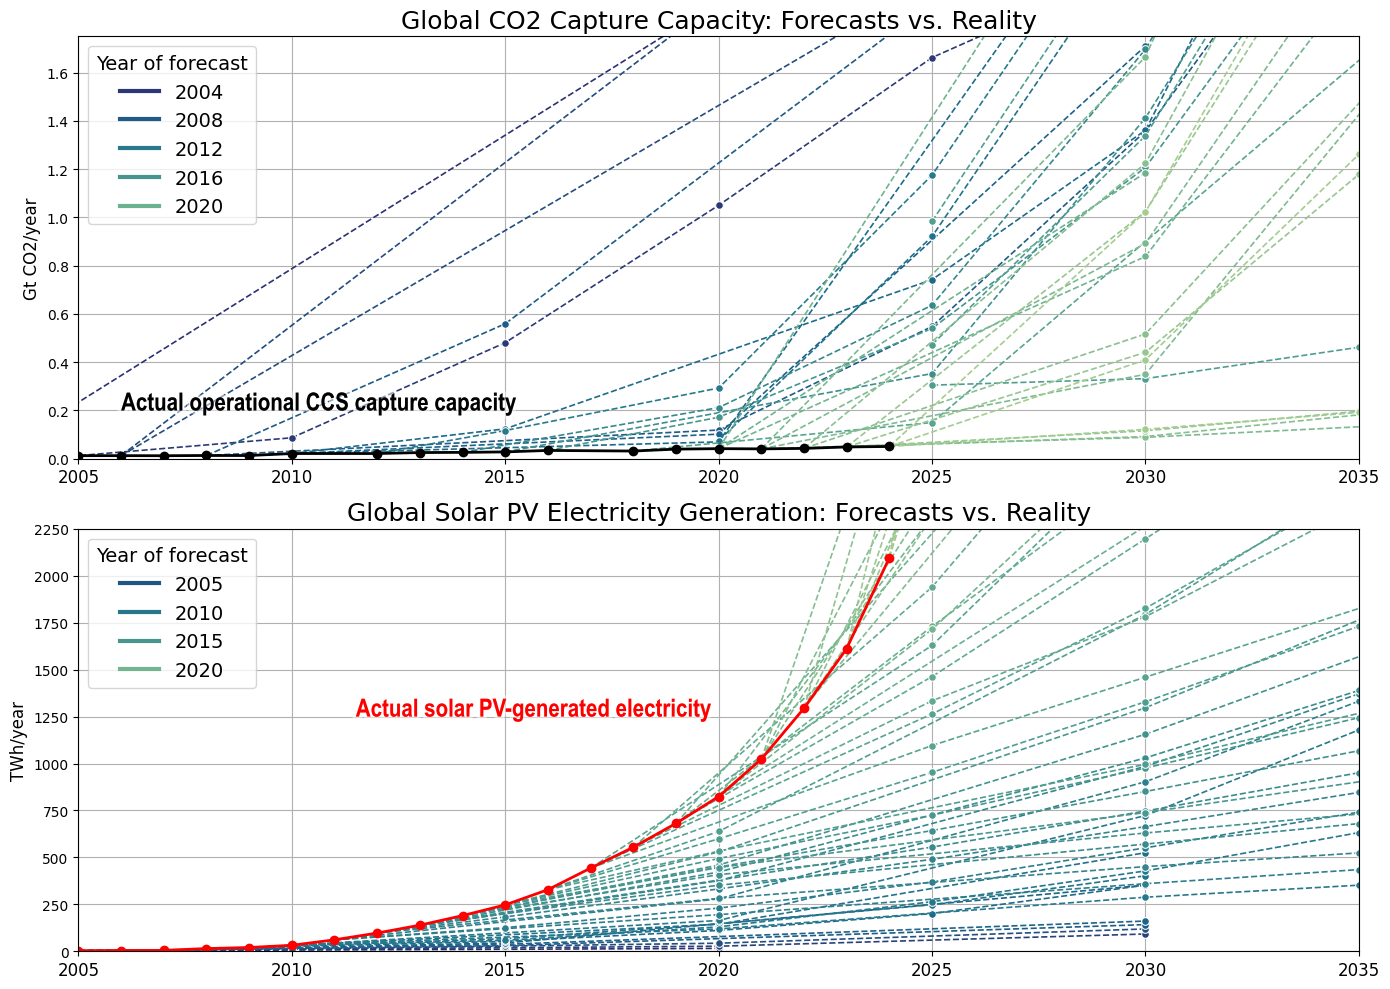

In [43]:
# add Gtco2 for plotting


# --- CCS CAPTURE CAPACITY ---
ccs_actual_df["gt_co2_per_yr"] = ccs_actual_df["mt_co2_per_yr"] / 1000
ccs_df["gt_co2_per_yr"] = ccs_df["mt_co2_per_yr"] / 1000
palette = "crest_r"  # "coolwarm"

marker = "."
font = "Arial Narrow"
weight = "semibold"
actualmarkersize = 12
actual_fontsize = 18
actuallinewidth = 2
ylabelsize = 12
startyear = 2005
endyear = 2035
projection_lw = 1.2
markersize = 11

title_fontsize = 18

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
# --- CCS
ax = axes[0]
sns.lineplot(
    data=ccs_df.loc[
        # (ccs_df["prediction_year"] != 2011) &
        (ccs_df["exclude_from_plot"] == 0)
    ],
    x="year",
    y="gt_co2_per_yr",
    hue="proj_uid",
    errorbar=None,
    palette=palette,
    linewidth=projection_lw,
    linestyle="--",
    marker=marker,
    markersize=markersize,
    ax=ax,
)
ax.set_xlim([startyear, endyear])
ax.set_ylim([0, 1.750])
ax.grid()
ax.plot(
    ccs_actual_df["year"],
    ccs_actual_df["gt_co2_per_yr"],
    "k",
    marker=".",
    linewidth=actuallinewidth,
    markersize=actualmarkersize,
)

# ax.plot(solar_co2_df["year"], solar_co2_df["mt_co2_per_yr"], "r", marker=".")
h, l = ax.get_legend_handles_labels()
for hh in h:
    hh.set_linewidth(3)
ax.legend(title="Year of forecast", title_fontsize=14, fontsize=14)
ax.tick_params(axis="x", which="major", labelsize=12)
ax.set_ylabel("Gt CO2/year", fontsize=ylabelsize)
ax.set_xlabel("")
ax.legend(h[:5], l[:5], title="Year of forecast", title_fontsize=14, fontsize=14)
ax.text(
    x=2006,
    y=0.200,
    s="Actual operational CCS capture capacity",
    fontsize=actual_fontsize,
    font=font,
    weight=weight,
    path_effects=[pe.withStroke(linewidth=5, foreground="w", alpha=0.5)],
)
ax.set_title(
    "Global CO2 Capture Capacity: Forecasts vs. Reality", fontsize=title_fontsize
)

# --- SOLAR PV ---

ax = axes[1]
sns.lineplot(
    data=pv_df.loc[pv_df.exclude_from_plot == 0],
    x="year",
    y="world_solar_pv_twh",
    hue="proj_uid",
    errorbar=None,
    palette="crest_r",
    ax=ax,
    marker=".",
    linewidth=projection_lw,
    linestyle="--",
    markersize=markersize,
)
ax.set_xlim([startyear, endyear])
ax.set_ylim([0, 2250])
ax.grid()
ax.plot(
    pv_actual_df["year"],
    pv_actual_df["world_solar_pv_twh"],
    "r",
    marker=".",
    linewidth=actuallinewidth,
    markersize=actualmarkersize,
)
ax.set_ylabel("TWh/year", fontsize=ylabelsize)
ax.set_xlabel("")
ax.text(
    x=2011.5,
    y=1250,
    s="Actual solar PV-generated electricity",
    fontsize=actual_fontsize,
    font=font,
    weight=weight,
    color="r",
    path_effects=[pe.withStroke(linewidth=5, foreground="w", alpha=0.5)],
)
h, l = ax.get_legend_handles_labels()
for hh in h:
    hh.set_linewidth(3)
ax.legend(title="Year of forecast", title_fontsize=14, fontsize=14)
ax.tick_params(axis="x", which="major", labelsize=12)
ax.set_title(
    "Global Solar PV Electricity Generation: Forecasts vs. Reality",
    fontsize=title_fontsize,
)
fig.tight_layout()
fig.savefig("forecast_vs_reality_ccs_and_pv.png")
fig.savefig("forecast_vs_reality_ccs_and_pv.tif", format="tif")

## Carbon dioxide kept out of the atmosphere by solar pv electricity generation

In [10]:
solar_co2_df = intensity_df.merge(
    pv_actual_df[["world_solar_pv_twh", "year"]], on="year"
)
solar_co2_df["mt_co2_per_yr"] = (
    (solar_co2_df["gco2_per_kwh"] / 1e6)
    * solar_co2_df["world_solar_pv_twh"]
    * 1e9
    / 1e6
)
solar_co2_df

,Entity,year,gco2_per_kwh,world_solar_pv_twh,mt_co2_per_yr
0,World,2000,517.84125,0.80,0.414273
1,World,2002,523.33260,1.00,0.523333
2,World,2004,530.91710,3.00,1.592751
3,World,2005,534.97253,3.00,1.604918
4,World,2006,538.35760,4.00,2.153430
5,World,2007,546.70140,5.00,2.733507
6,World,2008,540.01984,14.50,7.830288
7,World,2009,536.38910,20.00,10.727782
8,World,2010,536.85820,32.00,17.179462
9,World,2011,543.61914,61.00,33.160768
